In [1]:
#https://github.com/danasilver/seam-carving
import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt
def gaussian_blur(img):
    return cv2.GaussianBlur(img, (3, 3), 0, 0)
def x_gradient(img):
    return cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3,
                     scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
def y_gradient(img):
    return cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3,
                     scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
def energy(img):
    blurred = gaussian_blur(img)
    gray = grayscale(blurred)
    dx = x_gradient(gray)
    dy = y_gradient(gray)
    return cv2.add(np.absolute(dx), np.absolute(dy))
def cumulative_energies_vertical(energy):
    height, width = energy.shape[:2]
    energies = np.zeros((height, width))
    for i in range(1, height):
        for j in range(width):
            left = energies[i - 1, j - 1] if j - 1 >= 0 else 1e6
            middle = energies[i - 1, j]
            right = energies[i - 1, j + 1] if j + 1 < width else 1e6
            energies[i, j] = energy[i, j] + min(left, middle, right)
    return energies
def cumulative_energies_horizontal(energy):
    height, width = energy.shape[:2]
    energies = np.zeros((height, width))

    for j in range(1, width):
        for i in range(height):
            top = energies[i - 1, j - 1] if i - 1 >= 0 else 1e6
            middle = energies[i, j - 1]
            bottom = energies[i + 1, j - 1] if i + 1 < height else 1e6
            energies[i, j] = energy[i, j] + min(top, middle, bottom)
    return energies
def horizontal_seam(energies):
    height, width = energies.shape[:2]
    previous = 0
    seam = []

    for i in range(width - 1, -1, -1):
        col = energies[:, i]

        if i == width - 1:
            previous = np.argmin(col)

        else:
            top = col[previous - 1] if previous - 1 >= 0 else 1e6
            middle = col[previous]
            bottom = col[previous + 1] if previous + 1 < height else 1e6

            previous = previous + np.argmin([top, middle, bottom]) - 1

        seam.append([i, previous])

    return seam
def vertical_seam(energies):
    height, width = energies.shape[:2]
    previous = 0
    seam = []

    for i in range(height - 1, -1, -1):
        row = energies[i, :]

        if i == height - 1:
            previous = np.argmin(row)
            seam.append([previous, i])
        else:
            left = row[previous - 1] if previous - 1 >= 0 else 1e6
            middle = row[previous]
            right = row[previous + 1] if previous + 1 < width else 1e6

            previous = previous + np.argmin([left, middle, right]) - 1
            seam.append([previous, i])

    return seam
def draw_seam(img, seam, interactive=False):
    cv2.polylines(img, np.int32([np.asarray(seam)]), False, (0, 255, 0))
    cv2.imshow('seam', img)
    cv2.waitKey(1)

    if not interactive:
        cv2.destroyAllWindows()
def remove_horizontal_seam(img, seam):
    height, width, bands = img.shape
    removed = np.zeros((height - 1, width, bands), np.uint8)

    for x, y in reversed(seam):
        removed[0:y, x] = img[0:y, x]
        removed[y:height - 1, x] = img[y + 1:height, x]

    return removed
def remove_vertical_seam(img, seam):
    height, width, bands = img.shape
    removed = np.zeros((height, width - 1, bands), np.uint8)

    for x, y in reversed(seam):
        removed[y, 0:x] = img[y, 0:x]
        removed[y, x:width - 1] = img[y, x + 1:width]

    return removed
def window_callback(event, x, y, flags, param):
    """
    Mouse callback function.
    Get the points from mouse clicks.
    """
    global mx, my

    if event == cv2.EVENT_LBUTTONUP:
        mx, my = x, y
        print ('Clicked {} x {}.'.format(mx, my))
def resize(img, width=None, height=None, interactive=False):
    result = img

    img_height, img_width = img.shape[:2]

    if interactive:
        global mx, my
        mx, my = img_width, img_height

        cv2.namedWindow('seam', cv.CV_WINDOW_AUTOSIZE)
        cv.SetMouseCallback('seam', window_callback, img)
        cv2.imshow('seam', result)
        cv2.waitKey(0)

        print ('Resizing to {} (width) x {} (height).'.format(mx, my))
        
    if height is None:
        height = my

    if width is None:
        width = mx

    dy = img_height - height if img_height - height > 0 else 0
    dx = img_width - width if img_width - width > 0 else 0
        
    for i in range(dy):
        energies = cumulative_energies_horizontal(energy(result))
        seam = horizontal_seam(energies)
        draw_seam(result, seam, interactive=interactive)
        result = remove_horizontal_seam(result, seam)
        
    for i in range(dx):
        energies = cumulative_energies_vertical(energy(result))
        seam = vertical_seam(energies)
        draw_seam(result, seam, interactive=interactive)
        result = remove_vertical_seam(result, seam)

    cv2.imwrite('resized.jpg', result)

    cv2.imshow('seam', result)
def usage(program_name):
    print ('''Usage: python {} image [--interactive] [new_width new_height]
    --interactive        After starting the program, click in the window to pick
                         the height and width to resize to. Once you've made
                         your final selection, press any key to start the seam
                         carving process.
    new_width            The width to resize the image to.
    new_height           The height to resize the image to.
    '''.format(program_name))

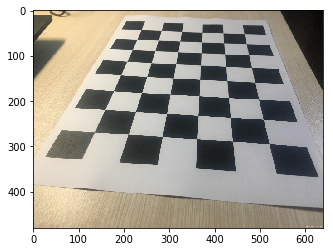

In [2]:
img = cv2.imread('原圖.jpg')
img = cv2.resize(img,(640,480))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [3]:
img.shape

(480, 640, 3)

In [4]:
resize(img, width=480, height=500)

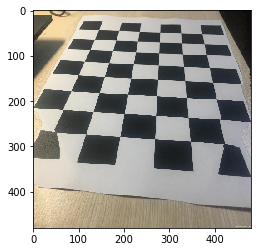

In [5]:
image = cv2.imread('原圖.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))